In [ ]:
#data collection through APIs
import numpy as np
import requests
import pandas as pd
import datetime
from time import sleep

class SpaceXDataExtractor:
    def __init__(self, static_json_url):
        self.static_json_url = static_json_url
        self.df = None

    def load_base_data(self):
        # Load static JSON data from IBM server
        response = requests.get(self.static_json_url)
        if response.status_code != 200:
            raise Exception("Failed to fetch base data")
        data = response.json()
        self.df = pd.json_normalize(data)

        # Subset required columns
        self.df = self.df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

        # Clean cores and payloads
        self.df = self.df[self.df['cores'].map(len) == 1]
        self.df = self.df[self.df['payloads'].map(len) == 1]
        self.df['cores'] = self.df['cores'].map(lambda x: x[0])
        self.df['payloads'] = self.df['payloads'].map(lambda x: x[0])

        # Parse date
        self.df['date'] = pd.to_datetime(self.df['date_utc']).dt.date

        # Filter date
        self.df = self.df[self.df['date'] <= datetime.date(2020, 11, 13)]

    def api_enrich(self, ids, endpoint, attribute):
        enriched_data = []
        for item_id in ids:
            url = f"https://api.spacexdata.com/v4/{endpoint}/{item_id}"
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    data = response.json()
                    enriched_data.append(data.get(attribute))
                else:
                    enriched_data.append(None)
            except Exception as e:
                enriched_data.append(None)
            sleep(0.1)  # slight delay to avoid hitting API too fast
        return enriched_data

    def enrich_all(self):
        self.df['BoosterVersion'] = self.api_enrich(self.df['rocket'], "rockets", "name")
        self.df['LaunchSite'] = self.api_enrich(self.df['launchpad'], "launchpads", "name")
        self.df['Longitude'] = self.api_enrich(self.df['launchpad'], "launchpads", "longitude")
        self.df['Latitude'] = self.api_enrich(self.df['launchpad'], "launchpads", "latitude")
        self.df['PayloadMass'] = self.api_enrich(self.df['payloads'], "payloads", "mass_kg")
        self.df['Orbit'] = self.api_enrich(self.df['payloads'], "payloads", "orbit")

        # Core data enrichment separately because nested structure
        self.get_core_data()

    def get_core_data(self):
        blocks, reused_counts, serials, outcomes, flights, gridfins, reuseds, legs, landingpads = [], [], [], [], [], [], [], [], []

        for core in self.df['cores']:
            try:
                response = requests.get(f"https://api.spacexdata.com/v4/cores/{core}")
                if response.status_code == 200:
                    data = response.json()
                    blocks.append(data.get("block"))
                    reused_counts.append(data.get("reuse_count"))
                    serials.append(data.get("serial"))
                else:
                    blocks.append(None)
                    reused_counts.append(None)
                    serials.append(None)
            except Exception as e:
                blocks.append(None)
                reused_counts.append(None)
                serials.append(None)

        # Now extract directly from original dataframe cores field
        for row in self.df['cores']:
            outcomes.append(str(row.get('landing_success')) + " " + str(row.get('landing_type')))
            flights.append(row.get('flight'))
            gridfins.append(row.get('gridfins'))
            reuseds.append(row.get('reused'))
            legs.append(row.get('legs'))
            landingpads.append(row.get('landpad'))

        self.df['Block'] = blocks
        self.df['ReusedCount'] = reused_counts
        self.df['Serial'] = serials
        self.df['Outcome'] = outcomes
        self.df['Flights'] = flights
        self.df['GridFins'] = gridfins
        self.df['Reused'] = reuseds
        self.df['Legs'] = legs
        self.df['LandingPad'] = landingpads

    def finalize_dataset(self):
        # Filter only Falcon 9 launches
        falcon9_df = self.df[self.df['BoosterVersion'] == 'Falcon 9'].copy()

        # Reset Flight Numbers
        falcon9_df.loc[:, 'FlightNumber'] = list(range(1, falcon9_df.shape[0]+1))

        # Handle missing PayloadMass
        payload_mass_mean = falcon9_df['PayloadMass'].mean()
        falcon9_df['PayloadMass'] = falcon9_df['PayloadMass'].fillna(payload_mass_mean)

        return falcon9_df

    def save_to_csv(self, df, filename="dataset_part_1.csv"):
        df.to_csv(filename, index=False)


# --- Usage Example ---
if __name__ == "__main__":
    static_json_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

    extractor = SpaceXDataExtractor(static_json_url)
    extractor.load_base_data()
    extractor.enrich_all()
    final_df = extractor.finalize_dataset()
    extractor.save_to_csv(final_df)
    print(final_df.head())


In [ ]:
#DATA GATHERING THROUGH WEB SCRABBING
import requests
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata

class WikipediaTableScraper:
    
    def __init__(self, url, table_index=0):
        self.url = url
        self.table_index = table_index
        self.soup = None
        self.table = None
        self.df = None

    def fetch_html(self):
        response = requests.get(self.url)
        if response.status_code != 200:
            raise Exception("Failed to fetch page")
        self.soup = BeautifulSoup(response.text, 'html.parser')

    def extract_table(self):
        tables = self.soup.find_all("table", {"class": ["wikitable", "sortable", "plainrowheaders", "collapsible"]})
        if len(tables) <= self.table_index:
            raise Exception("Table index out of range")
        self.table = tables[self.table_index]

    def clean_header(self, header_row):
        headers = []
        for th in header_row.find_all('th'):
            # Clean unwanted tags inside header
            for tag in ['br', 'a', 'sup']:
                if th.find(tag):
                    th.find(tag).extract()
            header = ' '.join(th.stripped_strings)
            headers.append(header)
        return headers

    def parse_row(self, row):
        cells = row.find_all(['th', 'td'])
        values = []
        for cell in cells:
            # Normalize unicode and remove leading/trailing spaces
            text = unicodedata.normalize("NFKD", cell.get_text(strip=True))
            values.append(text)
        return values

    def scrape(self):
        self.fetch_html()
        self.extract_table()

        header_row = self.table.find('tr')
        headers = self.clean_header(header_row)

        rows_data = []
        for row in self.table.find_all('tr')[1:]:
            parsed_row = self.parse_row(row)
            if parsed_row:  # ignore empty rows
                rows_data.append(parsed_row)

        self.df = pd.DataFrame(rows_data, columns=headers)
        return self.df


url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
scraper = WikipediaTableScraper(url, table_index=2)
spacex_df = scraper.scrape()

print(spacex_df.head())


In [ ]:
#DATA WANGLING OR I SHOULD SAY CLEANING
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.dtypes
numeric_features =  df.select_dtypes(include=['int64','float64']).columns.tolist()
categorial_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_transformers = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessing = ColumnTransformer(
    transformers=[
        ('num', numeric_transformers,numeric_features),
        ('cat', categorical_transformer,categorial_features)
    ]
)
#Handling the unknown values is done and also done with onehotencoding.

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [8]:
#Time for data visualisation
#DATA WANGLING OR I SHOULD SAY CLEANING
import pandas as pd
import plotly.express as ex
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.dtypes
numeric_features =  df.select_dtypes(include=['int64','float64']).columns.tolist()
categorial_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_transformers = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])
preprocessing = ColumnTransformer(
    transformers=[
        ('num', numeric_transformers,numeric_features),
        ('cat', categorical_transformer,categorial_features)
    ]
)
#Handling the unknown values is done. Time for get back the data
preprocesed = preprocessing.fit_transform(df)
all_features = numeric_features+categorial_features
preprocessed_df = pd.DataFrame(preprocesed, columns=all_features)
preprocessed_df['LandingPad'].isnull().sum()
preprocessed_df.head()
fig = ex.scatter(preprocessed_df, 
                 x='FlightNumber', 
                 y='LaunchSite', 
                 color='LaunchSite',
                 title='Flight Number vs Launch Site',
                 width=900,
                 height=500)

fig.show()
fig = ex.scatter(df, x='LaunchSite',y='PayloadMass', color='LaunchSite',
                 title='Payload vs Launch Site',
                 width=900,
                 height=500)
fig.show()

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, clas

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=lbfgs; total time=   0.0s
[CV] END classifier__C=1, classifier__

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/prantikroy/data science/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

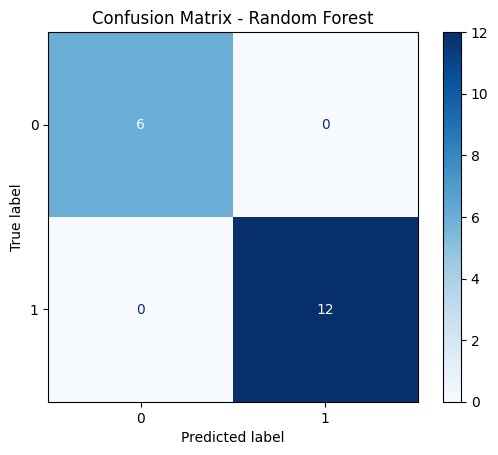

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df = pd.read_csv(URL1)
features = ['PayloadMass','Date', 'LaunchSite', 'Outcome', 'Serial', 'Longitude','Latitude']
target = ['Class']
y = df[target]
x = df[features]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y, random_state=42)
numeric_feature = x_train.select_dtypes(include = ['number']).columns.tolist()
categorial_featuer = x_train.select_dtypes(include=['object','category']).columns.tolist()
numeric_transfomers = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorial_transformers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessing = ColumnTransformer(
    transformers=[
        ('num', numeric_transfomers,numeric_feature),
        ('cat', categorial_transformers,categorial_featuer)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression())
])
param_grid = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

cv = StratifiedKFold(n_splits=10, shuffle=True)
logreg_cv = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=cv, scoring='accuracy', verbose=2)
logreg_cv.fit(x_train,y_train)
y_pred = logreg_cv.predict(x_test)
print(classification_report(y_test,y_pred))
best_score = logreg_cv.best_score_
print(best_score)
best_param = logreg_cv.best_params_
print(f'the best parameter is {best_param}')
cm = confusion_matrix(y_test, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_cv.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()



In [ ]:
import streamlit as st
import pandas as pd
import plotly.express as px

# PAGE CONFIG
st.set_page_config(page_title="🚀 SpaceX Launch Dashboard", layout="wide", page_icon="🛰️")

# CUSTOM CSS
st.markdown("""
    <style>
    html, body, [class*="css"] {
        font-family: 'Roboto', sans-serif;
        background-color: #FFFFFF;
        color: #000000 !important;
    }
    .block-container {
        padding-top: 2rem;
        padding-bottom: 2rem;
    }
    </style>
""", unsafe_allow_html=True)

# LOAD DATA
@st.cache_data
def load_data():
    url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv"
    df = pd.read_csv(url)
    return df

df = load_data()

# HEADER
st.title("🛰️ SpaceX Launch Dashboard")
st.markdown("Analyze SpaceX Launch Performance with Interactive Visualizations")

# SIDEBAR
st.sidebar.header("Filters")

# Dropdown for Launch Site
launch_sites = df['Launch Site'].unique().tolist()
launch_sites.insert(0, 'ALL')
selected_site = st.sidebar.selectbox("Select Launch Site:", launch_sites)

# Payload Slider
min_payload = df['Payload Mass (kg)'].min()
max_payload = df['Payload Mass (kg)'].max()
payload_range = st.sidebar.slider("Payload Range (kg):", float(min_payload), float(max_payload), (float(min_payload), float(max_payload)))

# PIE CHART
st.subheader("Launch Success Rate")

if selected_site == 'ALL':
    pie_data = df.groupby('Launch Site')['class'].sum().reset_index()
    fig_pie = px.pie(pie_data, values='class', names='Launch Site', title='Total Successful Launches by Site')
else:
    site_data = df[df['Launch Site'] == selected_site]
    site_success = site_data['class'].value_counts().reset_index()
    site_success.columns = ['Outcome', 'Count']
    fig_pie = px.pie(site_success, values='Count', names='Outcome', title=f'Success vs Failure: {selected_site}')

st.plotly_chart(fig_pie, use_container_width=True)

# SCATTER PLOT
st.subheader("Payload vs. Success Correlation")

filtered_df = df[(df['Payload Mass (kg)'] >= payload_range[0]) & (df['Payload Mass (kg)'] <= payload_range[1])]

if selected_site != 'ALL':
    filtered_df = filtered_df[filtered_df['Launch Site'] == selected_site]

fig_scatter = px.scatter(filtered_df, x='Payload Mass (kg)', y='class', color='Booster Version Category',
                         title='Payload Mass vs. Launch Success', template='plotly_white')

st.plotly_chart(fig_scatter, use_container_width=True)

st.markdown("---")
st.markdown("Crafted with ❤️ using Streamlit + Plotly + SpaceX Dataset 🚀")
